# Model Report

In [1]:
import logging
from time import time
from typing import Optional

import arviz as az
import matplotlib.pyplot as plt

from speclet import model_configuration
from speclet.analysis.arviz_analysis import describe_mcmc
from speclet.bayesian_models import get_bayesian_model
from speclet.io import project_root
from speclet.loggers import set_console_handler_level
from speclet.managers.cache_manager import (
    get_cached_posterior,
    get_posterior_cache_name,
)
from speclet.project_configuration import get_bayesian_modeling_constants
from speclet.project_enums import ModelFitMethod

In [2]:
notebook_tic = time()
set_console_handler_level(logging.WARNING)
%config InlineBackend.figure_format = "retina"
HDI_PROB = get_bayesian_modeling_constants().hdi_prob

Parameters for papermill:

- `MODEL_NAME`: name of the model
- `FIT_METHOD`: method used to fit the model; either "ADVI" or "MCMC"
- `CONFIG_PATH`: path to configuration file
- `ROOT_CACHE_DIR`: path to the root caching directory

## Setup

### Papermill parameters

In [3]:
CONFIG_PATH = ""
MODEL_NAME = ""
FIT_METHOD_STR = ""
ROOT_CACHE_DIR = ""

In [4]:
# Parameters
MODEL_NAME = "hierarchical-nb-second-tier"
FIT_METHOD_STR = "PYMC3_MCMC"
CONFIG_PATH = "models/model-configs.yaml"
ROOT_CACHE_DIR = "models"

In [5]:
FIT_METHOD = ModelFitMethod(FIT_METHOD_STR)
model_config = model_configuration.get_configuration_for_model(
    config_path=project_root() / CONFIG_PATH, name=MODEL_NAME
)
model = get_bayesian_model(model_config.model)()
trace = get_cached_posterior(
    get_posterior_cache_name(MODEL_NAME, FIT_METHOD),
    cache_dir=project_root() / ROOT_CACHE_DIR,
)

## Fit diagnostics

R-HAT
<xarray.Dataset>
Dimensions:      (gene: 114, one: 1, cell_line: 10, sgrna: 338, eta_dim_0: 2188, mu_dim_0: 2188)
Coordinates:
  * gene         (gene) object 'ACVR1C' 'ADAMTS2' ... 'ZC2HC1C' 'ZNF44'
  * cell_line    (cell_line) object 'ACH-000007' 'ACH-000087' ... 'ACH-002116'
  * sgrna        (sgrna) object 'AAACTTGCTGACGTGCCTGG' ... 'TTTGTTGGGACCAATGGAA'
  * one          (one) object '1'
  * eta_dim_0    (eta_dim_0) int64 0 1 2 3 4 5 ... 2182 2183 2184 2185 2186 2187
  * mu_dim_0     (mu_dim_0) int64 0 1 2 3 4 5 ... 2182 2183 2184 2185 2186 2187
Data variables: (12/18)
    mu_a         float64 0.9993
    a_g          (gene, one) float64 1.0 1.001 1.001 0.9995 ... 1.0 1.001 1.001
    delta_b      (one, cell_line) float64 1.001 0.9991 1.001 ... 1.001 1.001
    delta_gamma  (gene, cell_line) float64 1.005 1.001 0.9997 ... 1.003 1.004
    delta_beta   (sgrna, cell_line) float64 1.001 1.004 0.9994 ... 1.001 1.001
    sigma_a      float64 1.0
    ...           ...
    beta_sc      (s

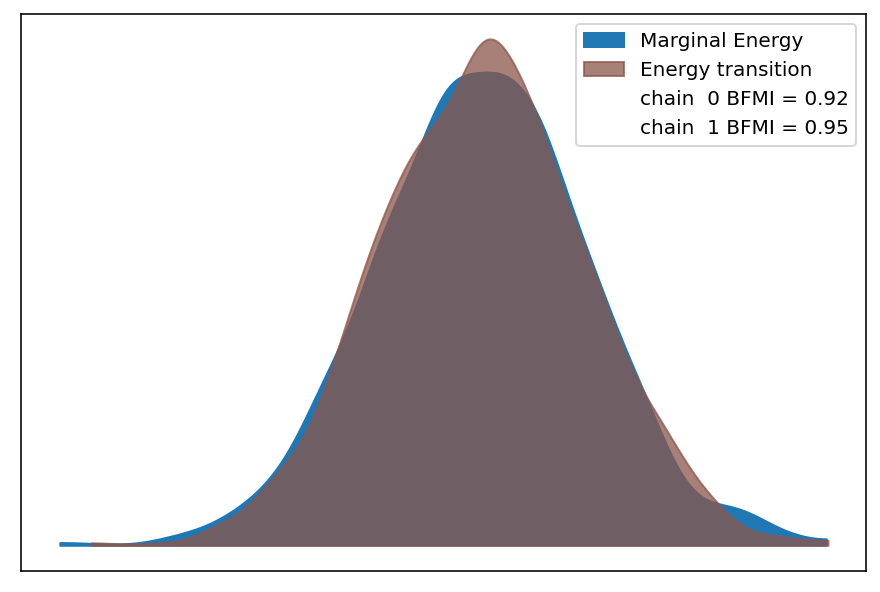

In [6]:
if "MCMC" in FIT_METHOD.value:
    print("R-HAT")
    print(az.rhat(trace))
    print("=" * 60)
    describe_mcmc(trace)

## Model parameters

In [7]:
var_regex = model.vars_regex(FIT_METHOD)
var_regex += ["~^log_lik$", "~^y_hat$"]

/usr/local/Caskroom/miniconda/base/envs/speclet_smk/lib/python3.9/site-packages/arviz/utils.py:124: UserWarning: Items starting with ~: ['^log_lik$', '^y_hat$'] have not been found and will be ignored
  warnings.warn(
/var/folders/r4/qpcdgl_14hbd412snp1jnv300000gn/T/ipykernel_3174/2160019948.py:2: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


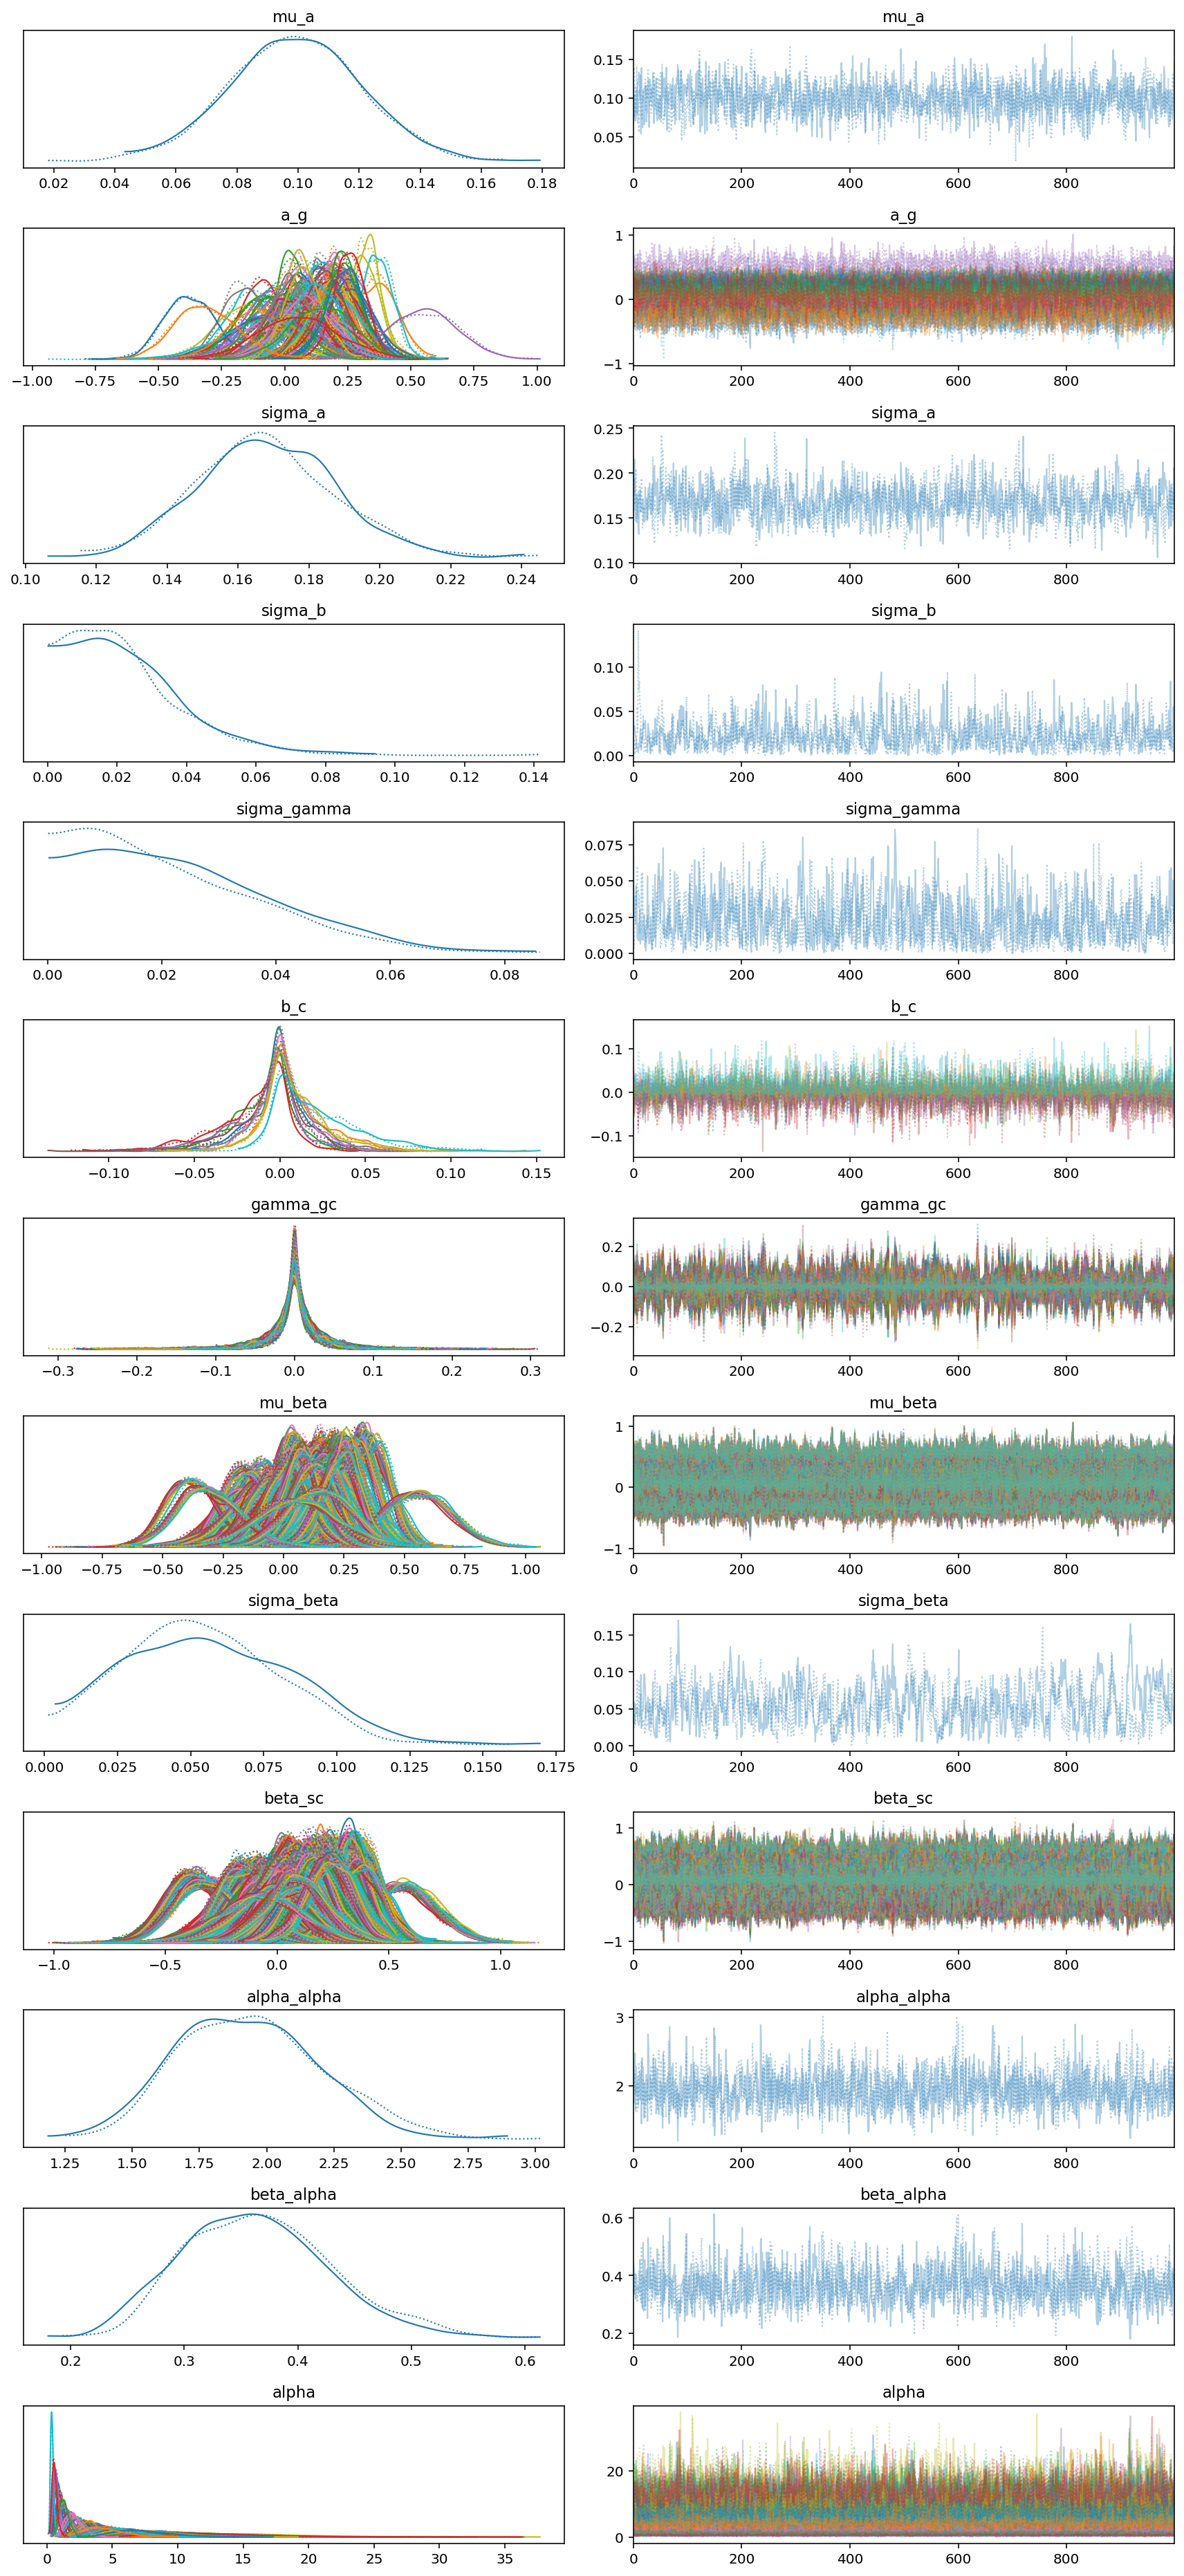

In [8]:
az.plot_trace(trace, var_names=var_regex, filter_vars="regex")
plt.tight_layout()
plt.show()

## Model predictions

/var/folders/r4/qpcdgl_14hbd412snp1jnv300000gn/T/ipykernel_3174/1880208410.py:13: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


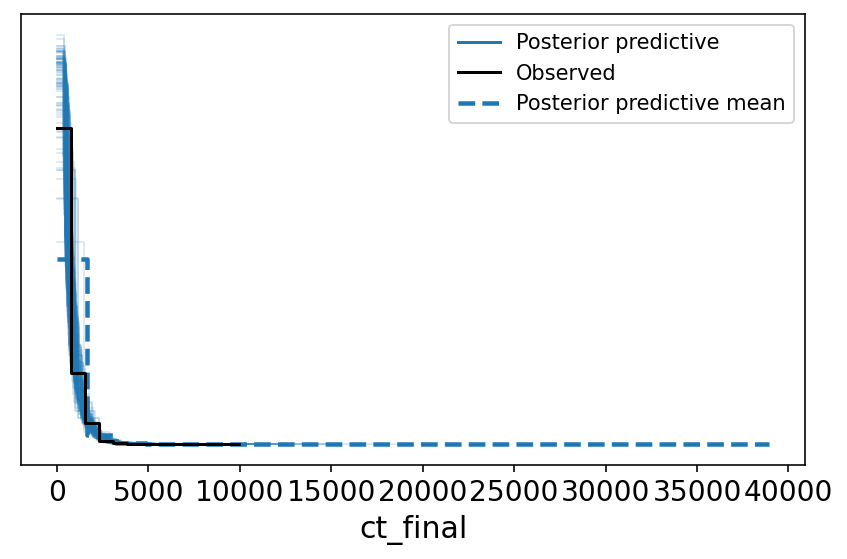

In [9]:
data_pairs: Optional[dict[str, str]] = None

# NOTE: This is a bit of a hack for now...
if FIT_METHOD is ModelFitMethod.STAN_MCMC:
    # obs_var = model.stan_idata_addons["observed_data"][0]
    # ppc_var = model.stan_idata_addons["posterior_predictive"][0]
    obs_var = list(trace.observed_data.data_vars.keys())[0]
    ppc_var = list(trace.posterior_predictive.data_vars.keys())[0]
    data_pairs = {obs_var: ppc_var}


az.plot_ppc(trace, data_pairs=data_pairs, num_pp_samples=100, random_seed=123)
plt.tight_layout()
plt.show()

In [10]:
psis_loo = az.loo(trace, pointwise=True)
psis_loo

/usr/local/Caskroom/miniconda/base/envs/speclet_smk/lib/python3.9/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 2000 by 2188 log-likelihood matrix

         Estimate       SE
elpd_loo -14685.54    52.91
p_loo      271.19        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     2064   94.3%
 (0.5, 0.7]   (ok)        100    4.6%
   (0.7, 1]   (bad)        20    0.9%
   (1, Inf)   (very bad)    4    0.2%

/var/folders/r4/qpcdgl_14hbd412snp1jnv300000gn/T/ipykernel_3174/3910446358.py:2: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


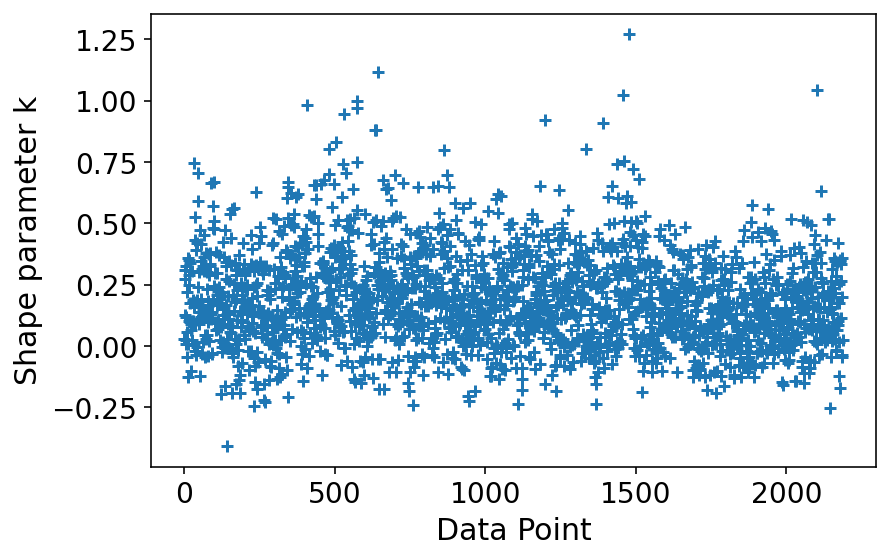

In [11]:
az.plot_khat(psis_loo)
plt.tight_layout()
plt.show()

---

In [12]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 6.54 minutes


In [13]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2022-01-26

Python implementation: CPython
Python version       : 3.9.9
IPython version      : 8.0.1

Compiler    : Clang 11.1.0 
OS          : Darwin
Release     : 21.2.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

Hostname: JHCookMac

Git branch: nb-model

logging   : 0.5.1.2
speclet   : 0.0.9000
arviz     : 0.11.2
matplotlib: 3.5.1

